# Déployez un modèle dans le cloud



In [1]:
# L'exécution de cette cellule démarre l'application Spark

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,User,Current session?
1,application_1691090312477_0002,pyspark,idle,Link,Link,None,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [2]:
%%info

ID,YARN Application ID,Kind,State,Spark UI,Driver log,User,Current session?
1,application_1691090312477_0002,pyspark,idle,Link,Link,None,✔


## Import des librairies

In [3]:
import pandas as pd
import numpy as np
import io
import os
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras import Model
from pyspark.sql.functions import col, pandas_udf, PandasUDFType, element_at, split, udf
from pyspark.ml.linalg import Vectors, VectorUDT 
from pyspark.ml.feature import StandardScaler, PCA
from pyspark.sql.types import StringType

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## Définition des PATH pour charger les images et enregistrer les résultats

Nous accédons directement à nos **données sur S3** comme si elles étaient **stockées localement**.

In [4]:
PATH = 's3://oc-p8-data'
PATH_Data = PATH+'/test_S3'
PATH_Result = PATH+'/Results'
print('PATH:        '+\
      PATH+'\nPATH_Data:   '+\
      PATH_Data+'\nPATH_Result: '+PATH_Result)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

PATH:        s3://oc-p8-data
PATH_Data:   s3://oc-p8-data/test_S3
PATH_Result: s3://oc-p8-data/Results

## Traitement des données
### Chargement des données

In [5]:
images = spark.read.format("binaryFile") \
  .option("pathGlobFilter", "*.jpg") \
  .option("recursiveFileLookup", "true") \
  .load(PATH_Data)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [6]:
images.show(5)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+-------------------+------+--------------------+
|                path|   modificationTime|length|             content|
+--------------------+-------------------+------+--------------------+
|s3://oc-p8-data/t...|2023-08-02 08:17:20|  5688|[FF D8 FF E0 00 1...|
|s3://oc-p8-data/t...|2023-08-02 08:17:20|  5684|[FF D8 FF E0 00 1...|
|s3://oc-p8-data/t...|2023-08-02 08:17:20|  5675|[FF D8 FF E0 00 1...|
|s3://oc-p8-data/t...|2023-08-02 08:17:20|  5648|[FF D8 FF E0 00 1...|
|s3://oc-p8-data/t...|2023-08-02 08:17:20|  5623|[FF D8 FF E0 00 1...|
+--------------------+-------------------+------+--------------------+
only showing top 5 rows

<u>Je ne conserve que le **path** de l'image et j'ajoute <br />
    une colonne contenant les **labels** de chaque image</u> :

In [7]:
images = images.withColumn('label', element_at(split(images['path'], '/'),-2))
print(images.printSchema())
print(images.select('path','label').show(5,False))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- path: string (nullable = true)
 |-- modificationTime: timestamp (nullable = true)
 |-- length: long (nullable = true)
 |-- content: binary (nullable = true)
 |-- label: string (nullable = true)

None
+--------------------------------------------+----------+
|path                                        |label     |
+--------------------------------------------+----------+
|s3://oc-p8-data/test_S3/Strawberry/4_100.jpg|Strawberry|
|s3://oc-p8-data/test_S3/Strawberry/3_100.jpg|Strawberry|
|s3://oc-p8-data/test_S3/Strawberry/6_100.jpg|Strawberry|
|s3://oc-p8-data/test_S3/Strawberry/5_100.jpg|Strawberry|
|s3://oc-p8-data/test_S3/Strawberry/8_100.jpg|Strawberry|
+--------------------------------------------+----------+
only showing top 5 rows

None

## Préparation du modèle

In [8]:
model = MobileNetV2(weights='imagenet',
                    include_top=True,
                    input_shape=(224, 224, 3))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

14540800/14536120 [==============================] - 1s 0us/step

In [9]:
new_model = Model(inputs=model.input,
                  outputs=model.layers[-2].output)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [10]:
new_model.summary()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
______________________________________________________________________________________________

In [11]:
brodcast_weights = sc.broadcast(new_model.get_weights())

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [12]:
def model_fn():
    """
    Returns a MobileNetV2 model with top layer removed 
    and broadcasted pretrained weights.
    """
    model = MobileNetV2(weights='imagenet',
                        include_top=True,
                        input_shape=(224, 224, 3))
    for layer in model.layers:
        layer.trainable = False
    new_model = Model(inputs=model.input,
                  outputs=model.layers[-2].output)
    new_model.set_weights(brodcast_weights.value)
    return new_model

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### Définition du processus de chargement des images et application <br/>de leur featurisation à travers l'utilisation de pandas UDF

In [13]:
def preprocess(content):
    """
    Preprocesses raw image bytes for prediction.
    """
    img = Image.open(io.BytesIO(content)).resize([224, 224])
    arr = img_to_array(img)
    return preprocess_input(arr)

def featurize_series(model, content_series):
    """
    Featurize a pd.Series of raw images using the input model.
    :return: a pd.Series of image features
    """
    input = np.stack(content_series.map(preprocess))
    preds = model.predict(input)
    # For some layers, output features will be multi-dimensional tensors.
    # We flatten the feature tensors to vectors for easier storage in Spark DataFrames.
    output = [p.flatten() for p in preds]
    return pd.Series(output)

@pandas_udf('array<float>', PandasUDFType.SCALAR_ITER)
def featurize_udf(content_series_iter):
    '''
    This method is a Scalar Iterator pandas UDF wrapping our featurization function.
    The decorator specifies that this returns a Spark DataFrame column of type ArrayType(FloatType).

    :param content_series_iter: This argument is an iterator over batches of data, where each batch
                              is a pandas Series of image data.
    '''
    # With Scalar Iterator pandas UDFs, we can load the model once and then re-use it
    # for multiple data batches.  This amortizes the overhead of loading big models.
    model = model_fn()
    for content_series in content_series_iter:
        yield featurize_series(model, content_series)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

/mnt1/yarn/usercache/livy/appcache/application_1691090312477_0002/container_1691090312477_0002_01_000001/pyspark.zip/pyspark/sql/pandas/functions.py:392: UserWarning: In Python 3.6+ and Spark 3.0+, it is preferred to specify type hints for pandas UDF instead of specifying pandas UDF type which will be deprecated in the future releases. See SPARK-28264 for more details.

### Exécution des actions d'extraction de features

In [15]:
# spark.conf.set("spark.sql.execution.arrow.maxRecordsPerBatch", "1024")

In [14]:
features_df = images.repartition(20).select(col("path"),
                                            col("label"),
                                            featurize_udf("content").alias("features")
                                           )

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [15]:
print(features_df.printSchema())

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- path: string (nullable = true)
 |-- label: string (nullable = true)
 |-- features: array (nullable = true)
 |    |-- element: float (containsNull = true)

None

In [16]:
print(PATH_Result)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

s3://oc-p8-data/Results

## Réduction de dimension - ACP

In [17]:
# Les données images sont converties au format vecteur dense
ud_f = udf(lambda r: Vectors.dense(r), VectorUDT())
vectorized_df = features_df.withColumn('image_vec', ud_f('features'))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [18]:
vectorized_df.show(5)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+----------+--------------------+--------------------+
|                path|     label|            features|           image_vec|
+--------------------+----------+--------------------+--------------------+
|s3://oc-p8-data/t...|Strawberry|[1.6238931, 0.0, ...|[1.62389314174652...|
|s3://oc-p8-data/t...|Strawberry|[1.6517094, 0.0, ...|[1.65170943737030...|
|s3://oc-p8-data/t...|Strawberry|[1.6780386, 0.0, ...|[1.67803859710693...|
|s3://oc-p8-data/t...|Strawberry|[1.5514317, 0.0, ...|[1.55143165588378...|
|s3://oc-p8-data/t...|Strawberry|[1.3925436, 0.0, ...|[1.39254355430603...|
+--------------------+----------+--------------------+--------------------+
only showing top 5 rows

In [19]:
standardizer = StandardScaler(withMean=True, withStd=True,
                              inputCol='image_vec',
                              outputCol='feats_scaled')

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [20]:
std = standardizer.fit(vectorized_df)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [21]:
features_df_scaled = std.transform(vectorized_df)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [22]:
features_df_scaled.printSchema()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- path: string (nullable = true)
 |-- label: string (nullable = true)
 |-- features: array (nullable = true)
 |    |-- element: float (containsNull = true)
 |-- image_vec: vector (nullable = true)
 |-- feats_scaled: vector (nullable = true)

In [23]:
features_df_scaled.show(5) 

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+----------+--------------------+--------------------+--------------------+
|                path|     label|            features|           image_vec|        feats_scaled|
+--------------------+----------+--------------------+--------------------+--------------------+
|s3://oc-p8-data/t...|Strawberry|[1.6238931, 0.0, ...|[1.62389314174652...|[1.02869159281593...|
|s3://oc-p8-data/t...|Strawberry|[1.6517094, 0.0, ...|[1.65170943737030...|[1.18999396328522...|
|s3://oc-p8-data/t...|Strawberry|[1.6780386, 0.0, ...|[1.67803859710693...|[1.34267266412390...|
|s3://oc-p8-data/t...|Strawberry|[1.5514317, 0.0, ...|[1.55143165588378...|[0.60849871036060...|
|s3://oc-p8-data/t...|Strawberry|[1.3925436, 0.0, ...|[1.39254355430603...|[-0.3128686697713...|
+--------------------+----------+--------------------+--------------------+--------------------+
only showing top 5 rows

In [24]:
# nombre de features par image
first_row = features_df_scaled.select("features").take(1)
print(" le nombre de features par image est de: ", len(first_row[0][0]))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

 le nombre de features par image est de:  1280

In [25]:
pca = PCA(k=300, inputCol="feats_scaled", outputCol="pca_feat")
modelpca = pca.fit(features_df_scaled)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [26]:
sum_var_pca = np.cumsum(modelpca.explainedVariance)

plt.figure(figsize=(12,8))
plt.title("Variance cumulée des composantes de l'ACP")
plt.xlabel("Nombre de composantes de l'ACP")
plt.ylabel("Variance cumulee")

plt.plot(range(len(sum_var_pca)), sum_var_pca)
plt.axhline(y=0.99, color='r', linestyle='--')
plt.axhline(y=0.9, color='g', linestyle='--')

plt.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

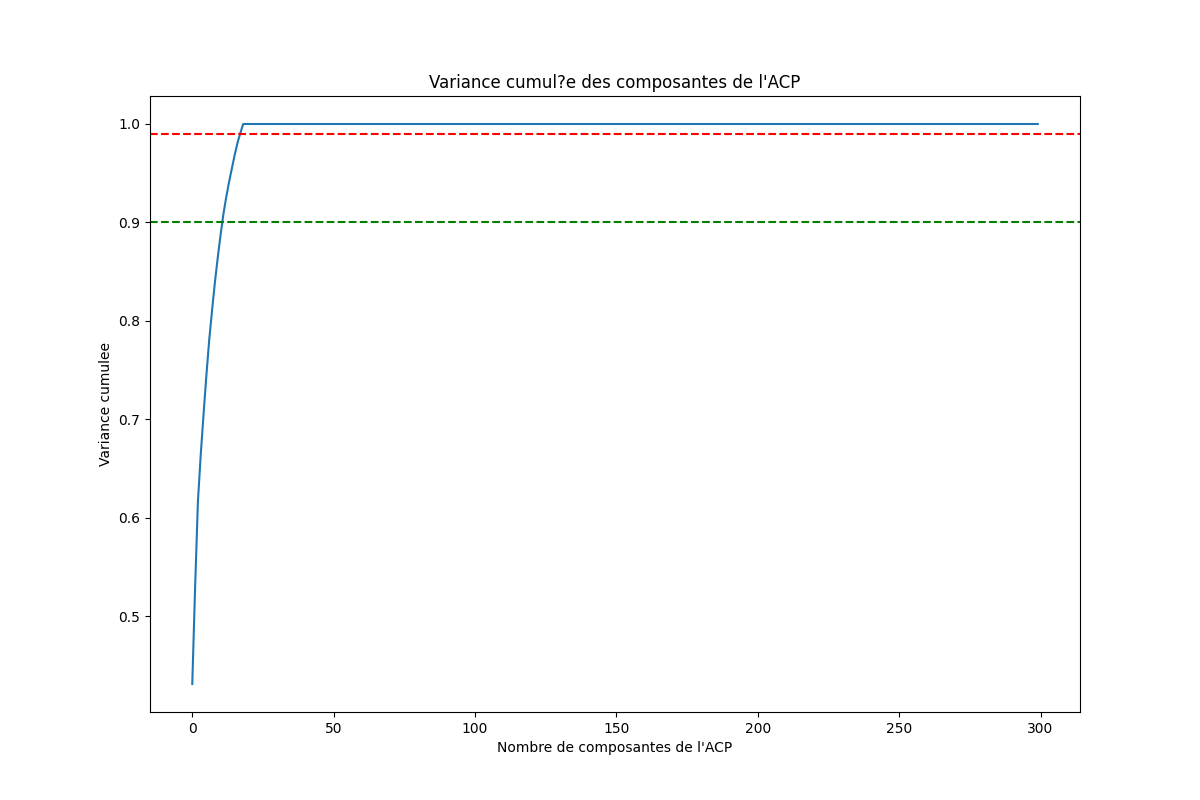

In [27]:
%matplot plt

In [30]:
sum_var_pca[15]

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

0.9685990813357553

In [31]:
pca_opti = PCA(k=15, inputCol="feats_scaled", outputCol="pca_feat")
modelpca_opti = pca_opti.fit(features_df_scaled)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [32]:
transformed = modelpca_opti.transform(features_df_scaled)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [33]:
transformed.show(5)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+----------+--------------------+--------------------+--------------------+--------------------+
|                path|     label|            features|           image_vec|        feats_scaled|            pca_feat|
+--------------------+----------+--------------------+--------------------+--------------------+--------------------+
|s3://oc-p8-data/t...|Strawberry|[1.6238931, 0.0, ...|[1.62389314174652...|[1.02869159281593...|[-23.124475010533...|
|s3://oc-p8-data/t...|Strawberry|[1.6517094, 0.0, ...|[1.65170943737030...|[1.18999396328522...|[-22.172758254422...|
|s3://oc-p8-data/t...|Strawberry|[1.6780386, 0.0, ...|[1.67803859710693...|[1.34267266412390...|[-22.997614421664...|
|s3://oc-p8-data/t...|Strawberry|[1.5514317, 0.0, ...|[1.55143165588378...|[0.60849871036060...|[-20.538450393867...|
|s3://oc-p8-data/t...|Strawberry|[1.3925436, 0.0, ...|[1.39254355430603...|[-0.3128686697713...|[-20.648800169446...|
+--------------------+----------+--------------------+--

In [34]:
df_final = transformed.select('path', 'label', 'pca_feat')

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [35]:
df_final.show(5)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+----------+--------------------+
|                path|     label|            pca_feat|
+--------------------+----------+--------------------+
|s3://oc-p8-data/t...|Strawberry|[-23.124475010533...|
|s3://oc-p8-data/t...|Strawberry|[-22.172758254422...|
|s3://oc-p8-data/t...|Strawberry|[-22.997614421664...|
|s3://oc-p8-data/t...|Strawberry|[-20.538450393867...|
|s3://oc-p8-data/t...|Strawberry|[-20.648800169446...|
+--------------------+----------+--------------------+
only showing top 5 rows

In [36]:
# Sauvegarde des donnees au format parquet dans S3

df_final.write.mode('overwrite').parquet(PATH_Result)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [37]:
# sauvegarde en format csv

format_udf = udf(lambda x: str(x), StringType()) 

df_csv = df_final.withColumn('pca_feat', format_udf(col('pca_feat')))

df_csv.write.mode("overwrite").option("delimiter", "\t").option("header","true").csv(PATH_Result + "_acp.csv")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### Chargement des données enregistrées et validation du résultat

In [38]:
df_pca = spark.read.parquet(PATH_Result)
df_pca = df_pca.toPandas()
df_pca.head(5)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

                                            path  ...                                           pca_feat
0  s3://oc-p8-data/test_S3/Strawberry/32_100.jpg  ...  [-21.98513107394924, -11.052900633744827, 0.83...
1      s3://oc-p8-data/test_S3/Banana/20_100.jpg  ...  [23.930971634054206, 2.259467342935945, 15.989...
2  s3://oc-p8-data/test_S3/Strawberry/34_100.jpg  ...  [-23.752466961370825, -23.45739446836916, 0.32...
3      s3://oc-p8-data/test_S3/Banana/16_100.jpg  ...  [22.28773028252083, 1.3979414450744243, 1.8190...
4  s3://oc-p8-data/test_S3/Strawberry/33_100.jpg  ...  [-21.5435106987867, -30.100936426295483, 2.025...

[5 rows x 3 columns]